## **Evaluate trained model**

In [1]:
from helper_functions import *

def load_model(MODEL_NAME):
    # Load the trained model
    model = get_object_detection_model(num_classes=4)
    # Load best version of model (lowest val loss)
    model.load_state_dict(torch.load(f"runs/{MODEL_NAME}/best.pth")) # NOTE! best / last
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    return model

model = load_model("202404211431_FasterRCNN_960")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Load validation data**

In [2]:
DATA_FOLDER = r'./fashion_v1/yolo'
CLASSES = ['bg', 'Hole', 'Stain', 'TUD']
IMG_WIDTH = 1280
IMG_HEIGHT = 720

val_dataset = FashionDataset(
    data_folder=DATA_FOLDER,
    split='val',
    width=IMG_WIDTH, height=IMG_HEIGHT,
    transform = A.Compose([
        ToTensorV2(p=1.0)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}))

print(f"Validation data has {len(val_dataset)} sample{'s' if len(val_dataset)>1 else ''}.")

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=4, shuffle=False, num_workers=4,
    collate_fn=utils.utils.collate_fn)

Validation data has 1 sample.


### **Evaluate with pycocoeval**

In [3]:
# Predict on validation data
model.eval()
eval_res = evaluate(model, val_loader, device=device)

creating index...
index created!


Evaluating...  [0/1]  eta: 0:00:01  model_time: 1.4891 (1.4891)  evaluator_time: 0.0006 (0.0006)  time: 1.6037  data: 0.1126  max mem: 644
Evaluating... Total time: 0:00:01 (1.6449 s / it)
Averaged stats: model_time: 1.4891 (1.4891)  evaluator_time: 0.0006 (0.0006)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.100
 Average Recall     (AR)

### **See some performance on images**

Predicted: 1 boxes
Actual: 1 boxes


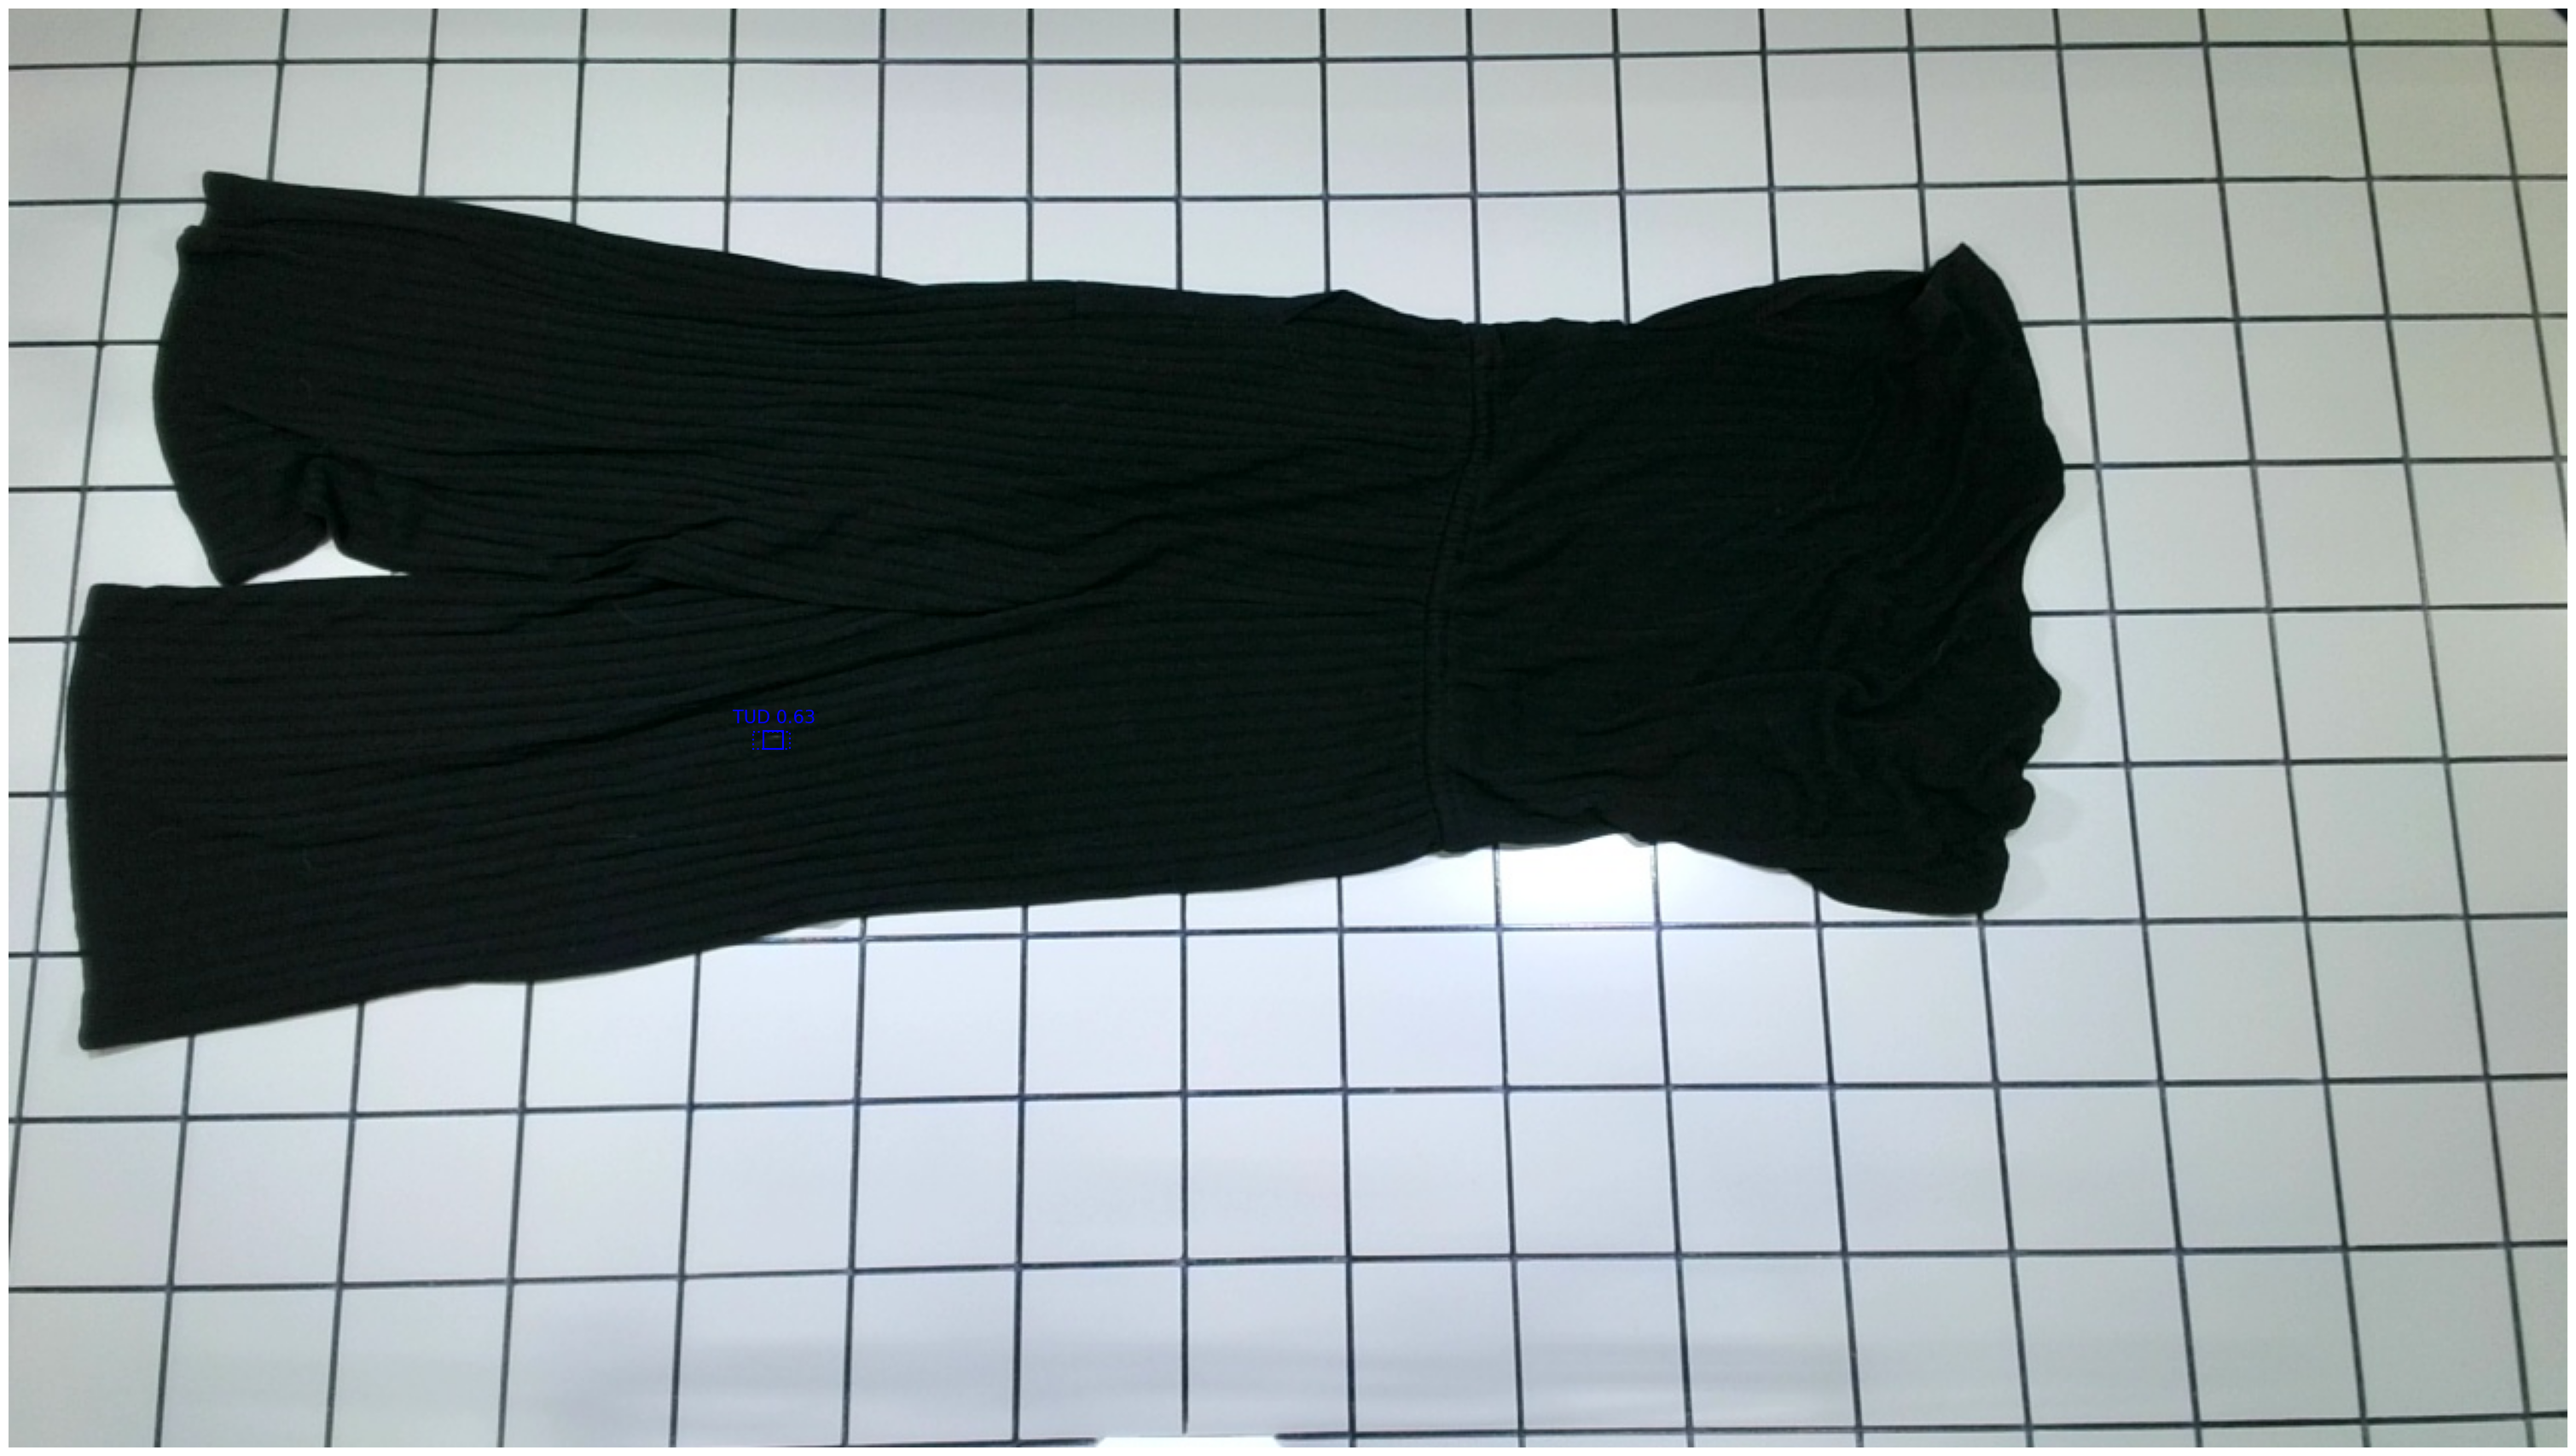

In [4]:
idx = 0
fig = predict_on_valid(model, val_dataset, CLASSES, idx, nms_tres=0.4, conf_tres=0.55)

# **Evaluation metrics**
By using the `torchmetrics` library, we can find mAP per class 👍

The class `ValidationMetric` is a wrapper class for calculating mAP for each class and diffrent IoU thresholds using the `torchmetrics` library.

In [5]:
CONF_thres = None
NMS_thres = None

res25 = ValidationMetric(model, val_loader, device, nms_tresh=NMS_thres, conf_tresh=CONF_thres, iou_thresholds=[0.25]).compute_mAP()
res50 = ValidationMetric(model, val_loader, device, nms_tresh=NMS_thres, conf_tresh=CONF_thres, iou_thresholds=[0.5]).compute_mAP()
res = ValidationMetric(model, val_loader, device, nms_tresh=NMS_thres, conf_tresh=CONF_thres).compute_mAP()

### mAP@[.50; .05; .95] 

In [6]:
res

{'map': 0.10000000149011612,
 'map_50': 1.0,
 'map_75': 0.0,
 'map_small': 0.10000000149011612,
 'map_medium': -1.0,
 'map_large': -1.0,
 'mar_1': 0.10000000149011612,
 'mar_10': 0.10000000149011612,
 'mar_100': 0.10000000149011612,
 'mar_small': 0.10000000149011612,
 'mar_medium': -1.0,
 'mar_large': -1.0,
 'map_per_class': [-1.0, 0.10000000149011612],
 'mar_100_per_class': [-1.0, 0.10000000149011612],
 'classes': [2, 3]}

### mAP@.50

In [7]:
res50

{'map': 1.0,
 'map_50': 1.0,
 'map_75': -1.0,
 'map_small': 1.0,
 'map_medium': -1.0,
 'map_large': -1.0,
 'mar_1': 1.0,
 'mar_10': 1.0,
 'mar_100': 1.0,
 'mar_small': 1.0,
 'mar_medium': -1.0,
 'mar_large': -1.0,
 'map_per_class': [-1.0, 1.0],
 'mar_100_per_class': [-1.0, 1.0],
 'classes': [2, 3]}

### mAP@.25

In [8]:
res25

{'map': 1.0,
 'map_50': -1.0,
 'map_75': -1.0,
 'map_small': 1.0,
 'map_medium': -1.0,
 'map_large': -1.0,
 'mar_1': 1.0,
 'mar_10': 1.0,
 'mar_100': 1.0,
 'mar_small': 1.0,
 'mar_medium': -1.0,
 'mar_large': -1.0,
 'map_per_class': [-1.0, 1.0],
 'mar_100_per_class': [-1.0, 1.0],
 'classes': [2, 3]}

# **Predict on images from test-folder**

Predicted: 0 boxes
Actual: 1 boxes


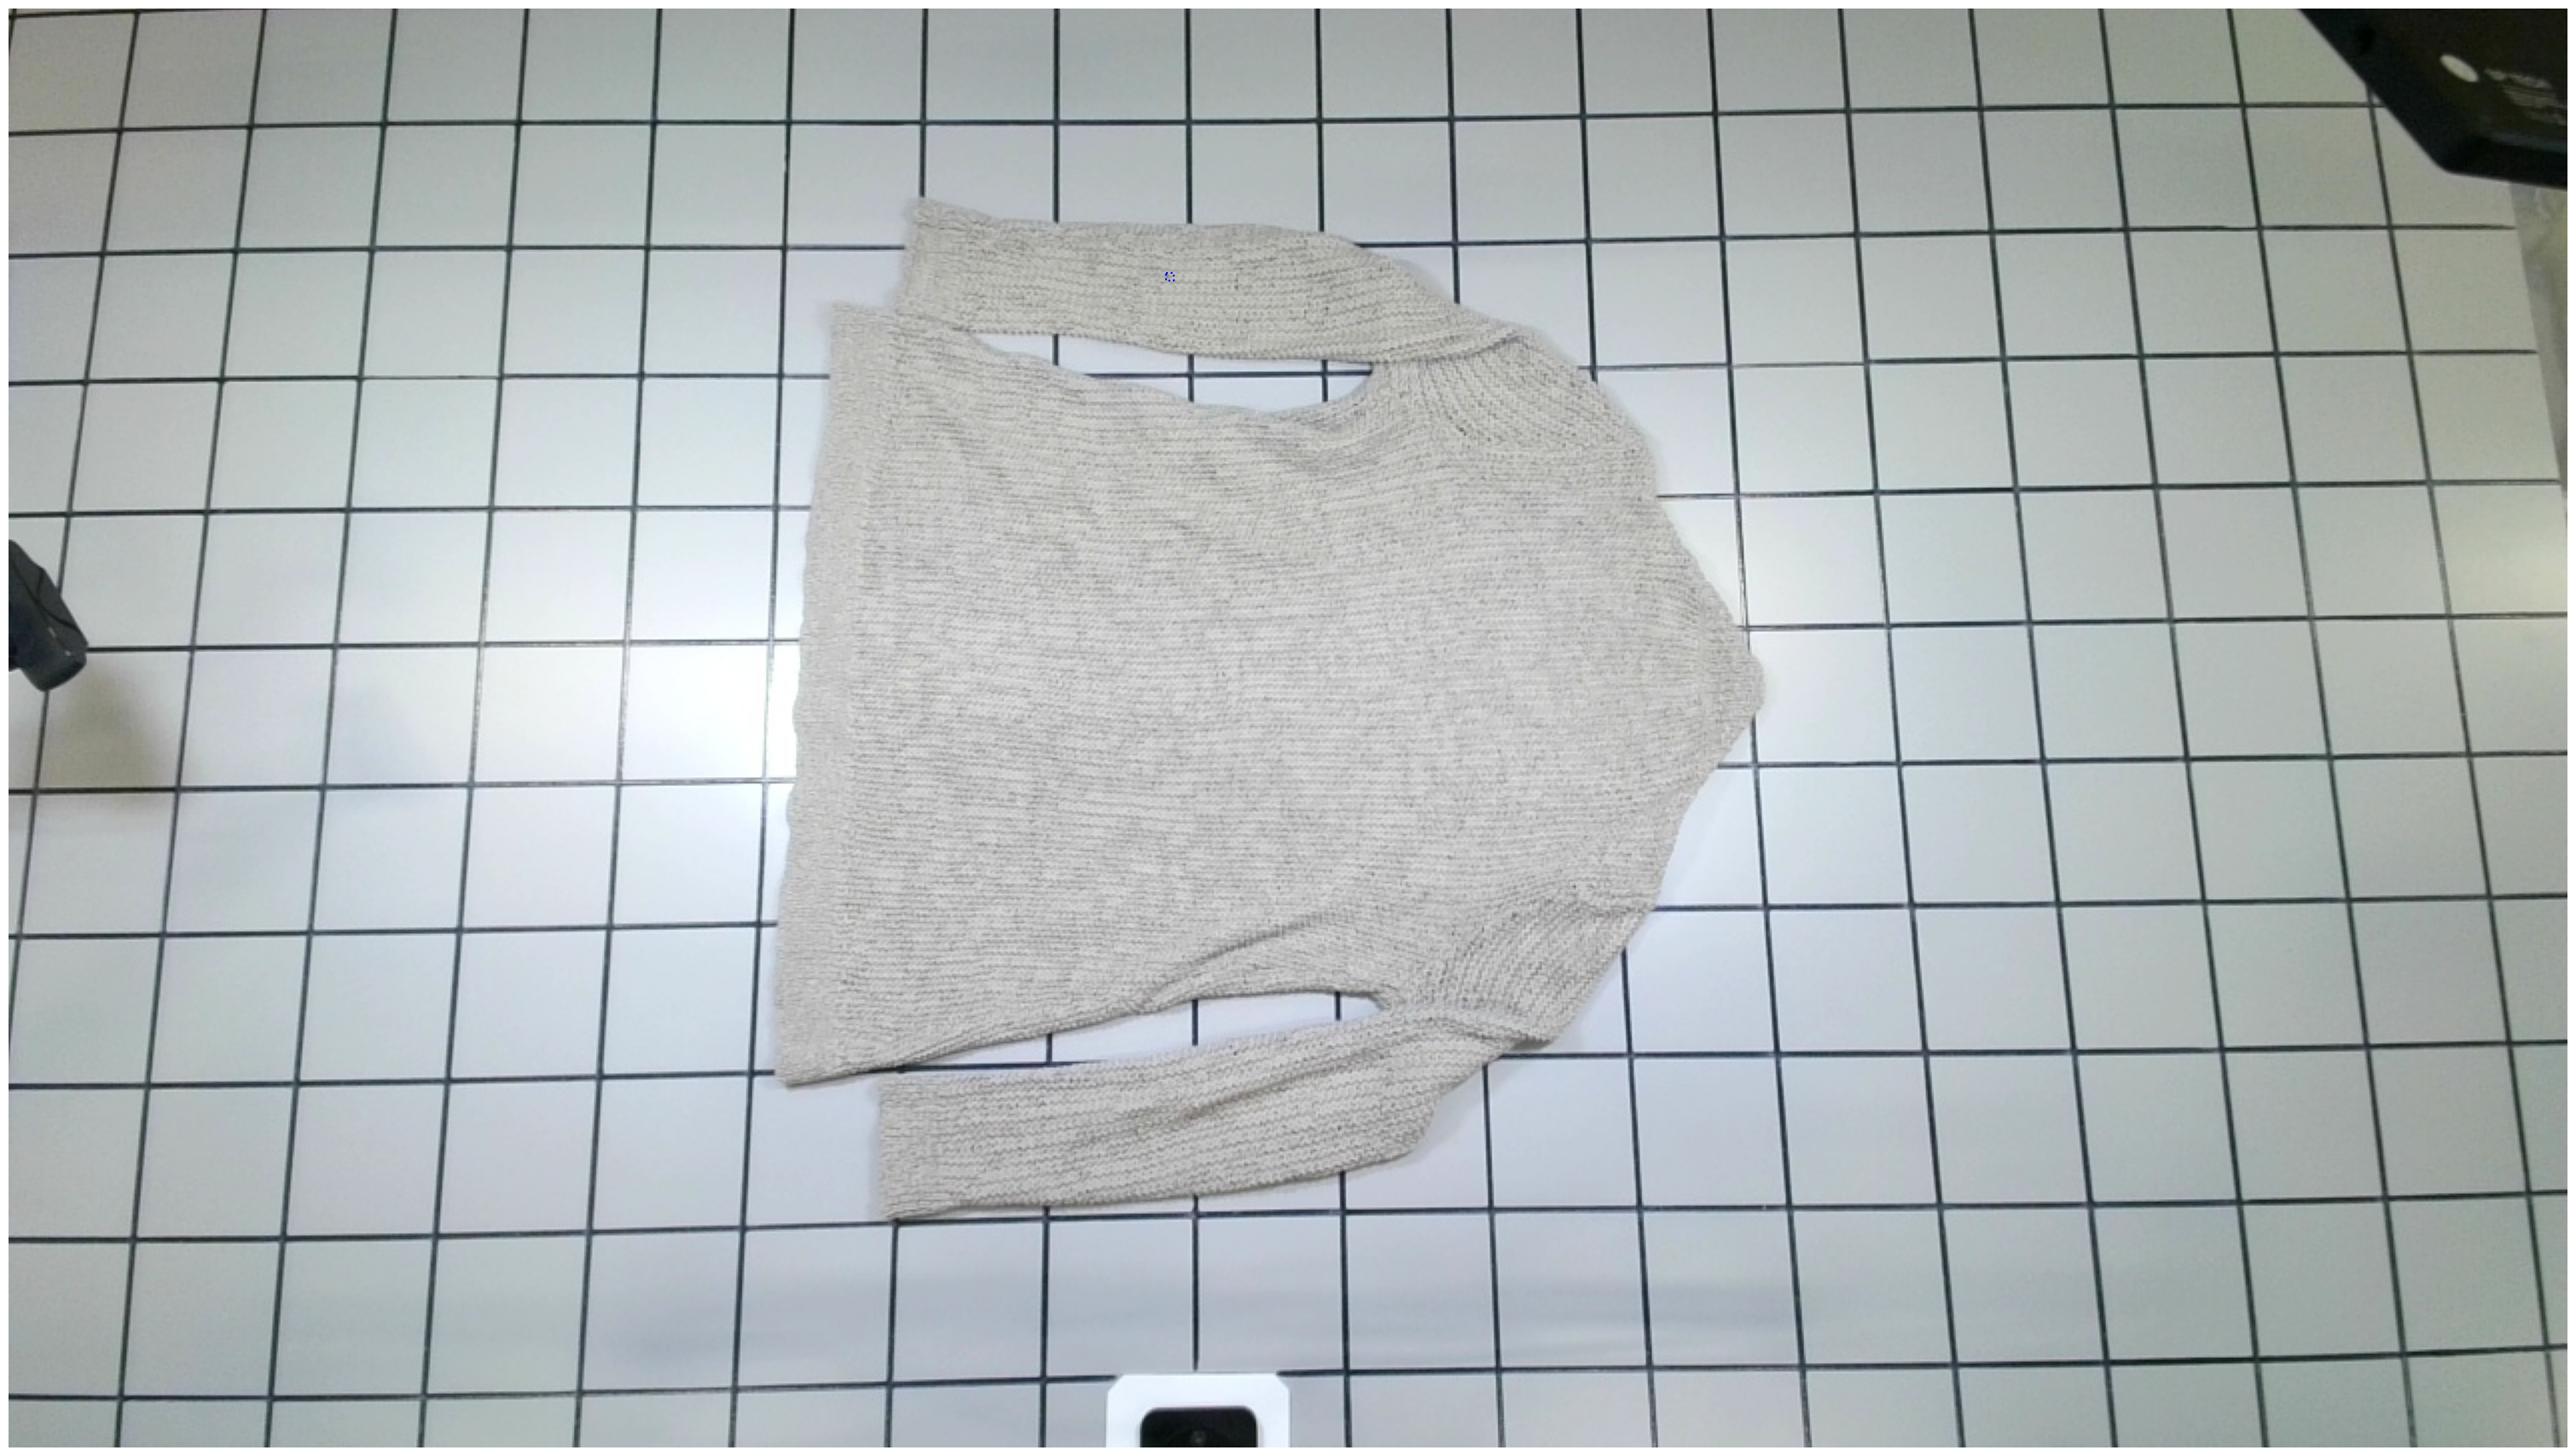

In [9]:
data_folder = "/home/leope744/Documents/fasterrcnn/fashion_v1/yolo"
split = "test"
sample_id ="back_2023_03_17_08_20_47.jpg"

pred = predict_on_image(model, data_folder, split, sample_id, CLASSES, nms_tres=0.4, conf_tres=0.55)#, save_path=rf'/home/leope744/Documents/fasterrcnn/predictions_on_img/{sample_id[:-4]}.pdf')